In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.cluster import KMeans
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [53]:
# Load the dataset
data_path = '../Data/partial_data.csv'
taxi_data = pd.read_csv(data_path)

# 1. Data Preprocessing
# Convert datetime columns to datetime objects
taxi_data[' pickup_datetime'] = pd.to_datetime(taxi_data[' pickup_datetime'])
taxi_data[' dropoff_datetime'] = pd.to_datetime(taxi_data[' dropoff_datetime'])

# Remove invalid or zero values
taxi_data = taxi_data[
    (taxi_data[' trip_distance'] > 0) &
    (taxi_data[' trip_time_in_secs'] > 0) &
    (taxi_data[' pickup_longitude'] < -71) &
    (taxi_data[' pickup_longitude'] > -78) &
    (taxi_data[' pickup_latitude'] > 0) &
    (taxi_data[' dropoff_longitude'] < -71) &
    (taxi_data[' dropoff_longitude'] > -78) &
    (taxi_data[' dropoff_latitude'] > 0)
]


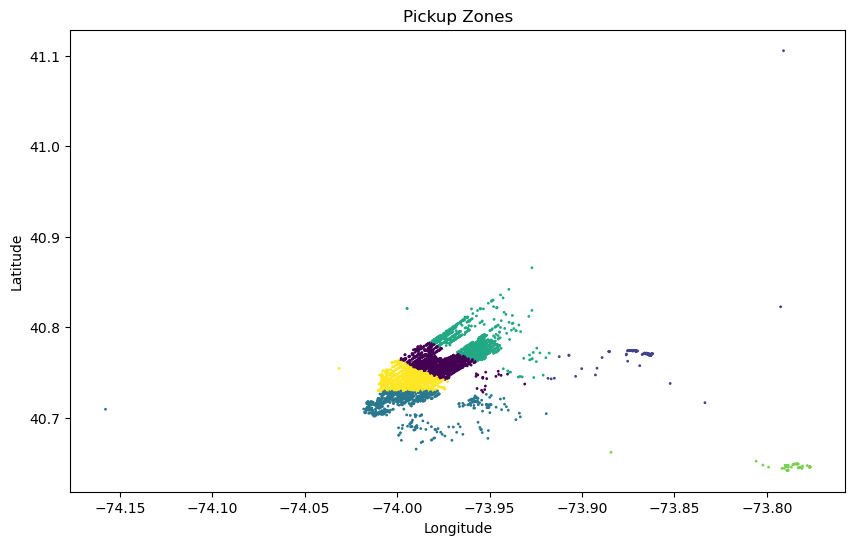

In [55]:
# 2. Feature Engineering
# Trip duration in minutes
taxi_data[' trip_duration_minutes'] = taxi_data[' trip_time_in_secs'] / 60

# Extract time features
taxi_data[' pickup_hour'] = taxi_data[' pickup_datetime'].dt.hour
taxi_data[' pickup_weekday'] = taxi_data[' pickup_datetime'].dt.weekday

# Calculate Haversine distance
coords_pickup = np.radians(taxi_data[[' pickup_latitude', ' pickup_longitude']])
coords_dropoff = np.radians(taxi_data[[' dropoff_latitude', ' dropoff_longitude']])
earth_radius_km = 6371
taxi_data[' haversine_distance_km'] = haversine_distances(coords_pickup, coords_dropoff).diagonal() * earth_radius_km

# Cluster pickup locations into zones using K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
taxi_data[' pickup_zone'] = kmeans.fit_predict(coords_pickup)

# Visualize zones
plt.figure(figsize=(10, 6))
plt.scatter(taxi_data[' pickup_longitude'], taxi_data[' pickup_latitude'], c=taxi_data[' pickup_zone'], cmap='viridis', s=1)
plt.title('Pickup Zones')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Extract centroids
centroids = kmeans.cluster_centers_
centroids_degrees = np.degrees(centroids)

# Create a map
city_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12) 

# Add centroids to the map
for i, (lat, lon) in enumerate(centroids_degrees):
    folium.Marker(
        location=[lat, lon],
        popup=f"Zone {i}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(city_map)

# Display the map
city_map.save("pickup_zones_map.html")

# One-hot encode categorical features
taxi_data = pd.get_dummies(taxi_data, columns=[' pickup_weekday'], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = [' pickup_hour', ' passenger_count', ' trip_distance', ' trip_duration_minutes', ' haversine_distance_km']
taxi_data[numerical_features] = scaler.fit_transform(taxi_data[numerical_features])


In [56]:
# 3. Classification Setup
# Define features and target
features = [' pickup_hour', ' passenger_count', ' trip_distance', ' trip_duration_minutes', ' haversine_distance_km']
target = ' pickup_zone'

X = taxi_data[features]
y = taxi_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Address imbalance by using Stratified K-Folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search for Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(class_weight="balanced", random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and classifier
grid_best_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions
y_pred = grid_best_clf.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=10, min_sa

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.26      0.31       419
           1       0.52      0.87      0.65        47
           2       0.29      0.32      0.30       262
           3       0.33      0.40      0.36       275
           4       0.37      0.87      0.52        15
           5       0.38      0.38      0.38       447

    accuracy                           0.36      1465
   macro avg       0.38      0.52      0.42      1465
weighted avg       0.36      0.36      0.35      1465


Confusion Matrix:
[[111  11  67  77   8 145]
 [  0  41   3   1   2   0]
 [ 45   8  84  63   3  59]
 [ 43   7  46 111   3  65]
 [  0   1   1   0  13   0]
 [ 89  11  89  84   6 168]]

Accuracy: 0.3604095563139932
Precision: 0.3617990989889819
Recall: 0.3604095563139932
F-Score: 0.35461586125609085


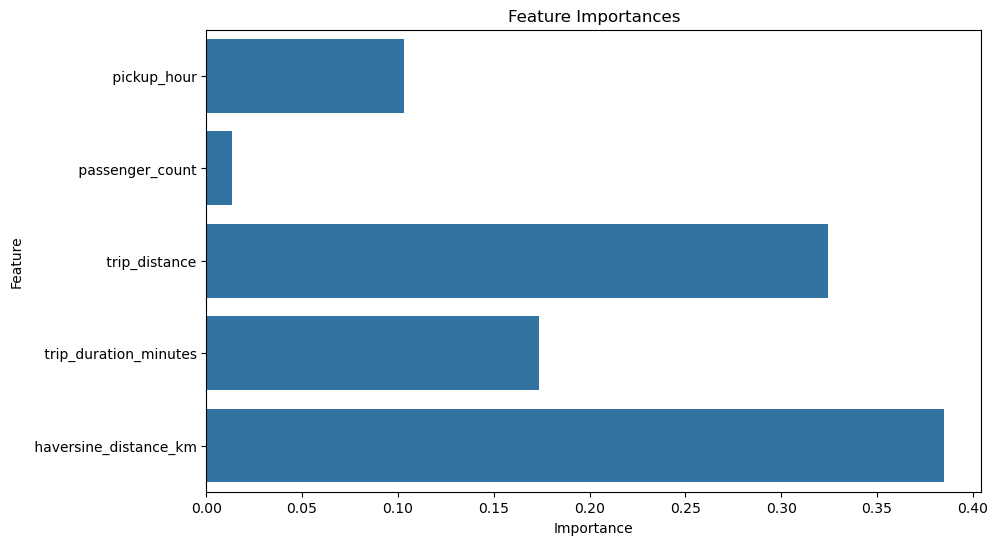

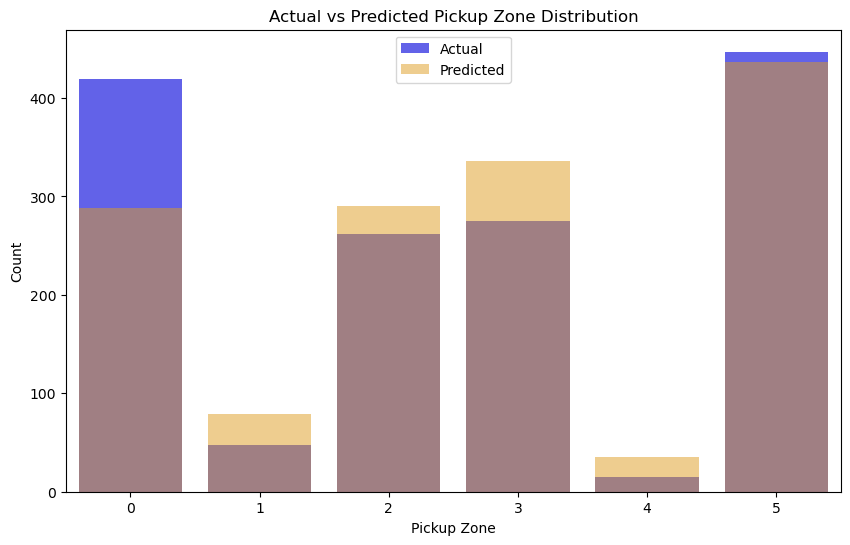

In [57]:
# 4. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-Score:", f1)

# Visualize Feature Importance
importances = grid_best_clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Visualize Actual vs Predicted Zone Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, color='blue', alpha=0.7, label='Actual')
sns.countplot(x=y_pred, color='orange', alpha=0.5, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Pickup Zone Distribution')
plt.xlabel('Pickup Zone')
plt.ylabel('Count')
plt.show()
